# Evaluation of MobileNet V2 and ResNet-18 using CIFAR-10
In this notebook, we will evaluate two distinct architectures MobileNetV2 (optimized for efficiency) and ResNet-18 (optimized for feature extraction accuracy) on the CIFAR-10 dataset.

> we aim to answer:

- How did the models learn? -> by loss curves
- Which model is better overall? -> metrics accuracy and f1-score
- Where does model fail? -> confusion matrix
- What is the cost? -> inference time + number of parameters

## Setup

In [1]:
import os, sys, time, torch, dataframe_image as dfi, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

from pathlib import Path
ROOT = Path().resolve().parent
sys.path.insert(0, str(ROOT))

from model import TransferModel
from data_preparation.CIFAR_10.data_cifar_10 import test_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Files already downloaded and verified
Files already downloaded and verified
Running on: cpu


Store class labels from CIFAR-10

In [2]:
class_labels = test_loader.dataset.classes
dataset_name='CIFAR-10'

Import data for evaluation from training phase for ResNet-18, where data we can divide by training strategy (head-only, lastblock, fine-tuned)

<br>List of true labels (y_true) and predicted values (y_pred) was taken from full-tuning training.

In [3]:
data_path = ROOT / 'data_evaluation_resnet18' / 'CIFAR_10' # path for data evaluation

# import csv
resnet_finetuned = pd.read_csv(data_path / 'resnet18_cifar10_full_best_training_history.csv')
resnet_head = pd.read_csv(data_path / 'resnet18_cifar10_head_best_training_history.csv')
resnet_lastblock = pd.read_csv(data_path / 'resnet18_cifar10_lastblock_best_training_history.csv')

# import and initialisation of model
resnet_model = TransferModel(num_classes=10, backbone='resnet18', pretrained=True).to(device)
resnet_model_path=data_path / 'resnet18_cifar10_full_best.pth'
resnet_model.load_state_dict(torch.load(resnet_model_path, map_location=device))
print("Model instance successfully created and weights loaded")

test_pred = pd.read_csv(data_path / 'resnet18_test_predictions.csv')
resnet_y_true, resnet_y_pred = test_pred.True_Label, test_pred.Predicted_Label

Model instance successfully created and weights loaded


And import for MobiliNet V2

In [4]:
data_path = ROOT / 'data_evaluation_mobilenet_v2' / 'CIFAR_10' # path for data evaluation

# import csv
mobilinet_finetuned = pd.read_csv(data_path / 'mobilenet_v2_cifar10_full_best_training_history.csv')
mobilinet_head = pd.read_csv(data_path / 'mobilenet_v2_cifar10_head_best_training_history.csv')
mobilinet_lastblock = pd.read_csv(data_path / 'mobilenet_v2_cifar10_lastblock_best_training_history.csv')

# import and initialisation of model
mobilinet_model = TransferModel(num_classes=10, backbone='mobilenet_v2', pretrained=True).to(device)
mobilinet_model_path=data_path / 'mobilenet_v2_cifar10_full_best.pth'
mobilinet_model.load_state_dict(torch.load(mobilinet_model_path, map_location=device))
print("Model instance successfully created and weights loaded")

test_pred = pd.read_csv(data_path / 'mobilenet_v2_test_predictions.csv')
mobilinet_y_true, mobilinet_y_pred = test_pred.True_Label, test_pred.Predicted_Label

Model instance successfully created and weights loaded


## Part I: Training Dynamics (Learning Curves & Strategies)

In this section we will compare how well model was trained during 3 different transfer learning strategies:
* **Full fine-tuning (full)** -> Training all layers of the network.
* **Linear probing (head)** -> Training only the final classification head while keeping the backbone frozen.
* **Partial fine-tuning (last)** -> Unfreezing the final blocks of the MobileNet architecture to allow for feature adaptation.

### Training Loss vs Validation Loss

These graphs will show us how well model generalizes to unseen data depending on which training strategy was used.

In [5]:
#helper func
def plot_training_analytics(df:list[pd.DataFrame], ax, *metrics:str, title:str='', axis_labels:list[str]=None, labels:list[str]=None):
    """
    df - can be single DataFrame or list of DataFrame
    ax - ax from plt
    *metrics - list of metrics what to plot
    title - define title for plot 
    axis_labels - [label_x, label_y] to plot specific labels for axes
    labels - to lable specificly each plotted data
    """
    for metric in metrics:
        for i, df in enumerate(df if type(df)==list else [df]):
            ax.plot(df.index, df[metric], label=labels[i] if labels else metric, marker='o')
            
            if axis_labels: 
                ax.set_xlabel(axis_labels[0])
                ax.set_ylabel(axis_labels[1])
        
            ax.set_title(title, fontweight='bold', fontsize=10)
            ax.grid(alpha=0.3)
            ax.legend()

Generate difference between validation losses and training losses -> generalisation gap

In [6]:
for df in [mobilinet_finetuned,mobilinet_head,mobilinet_lastblock,resnet_finetuned,resnet_head,resnet_lastblock]:
    df['gap'] = df['val_loss'] - df['train_loss']

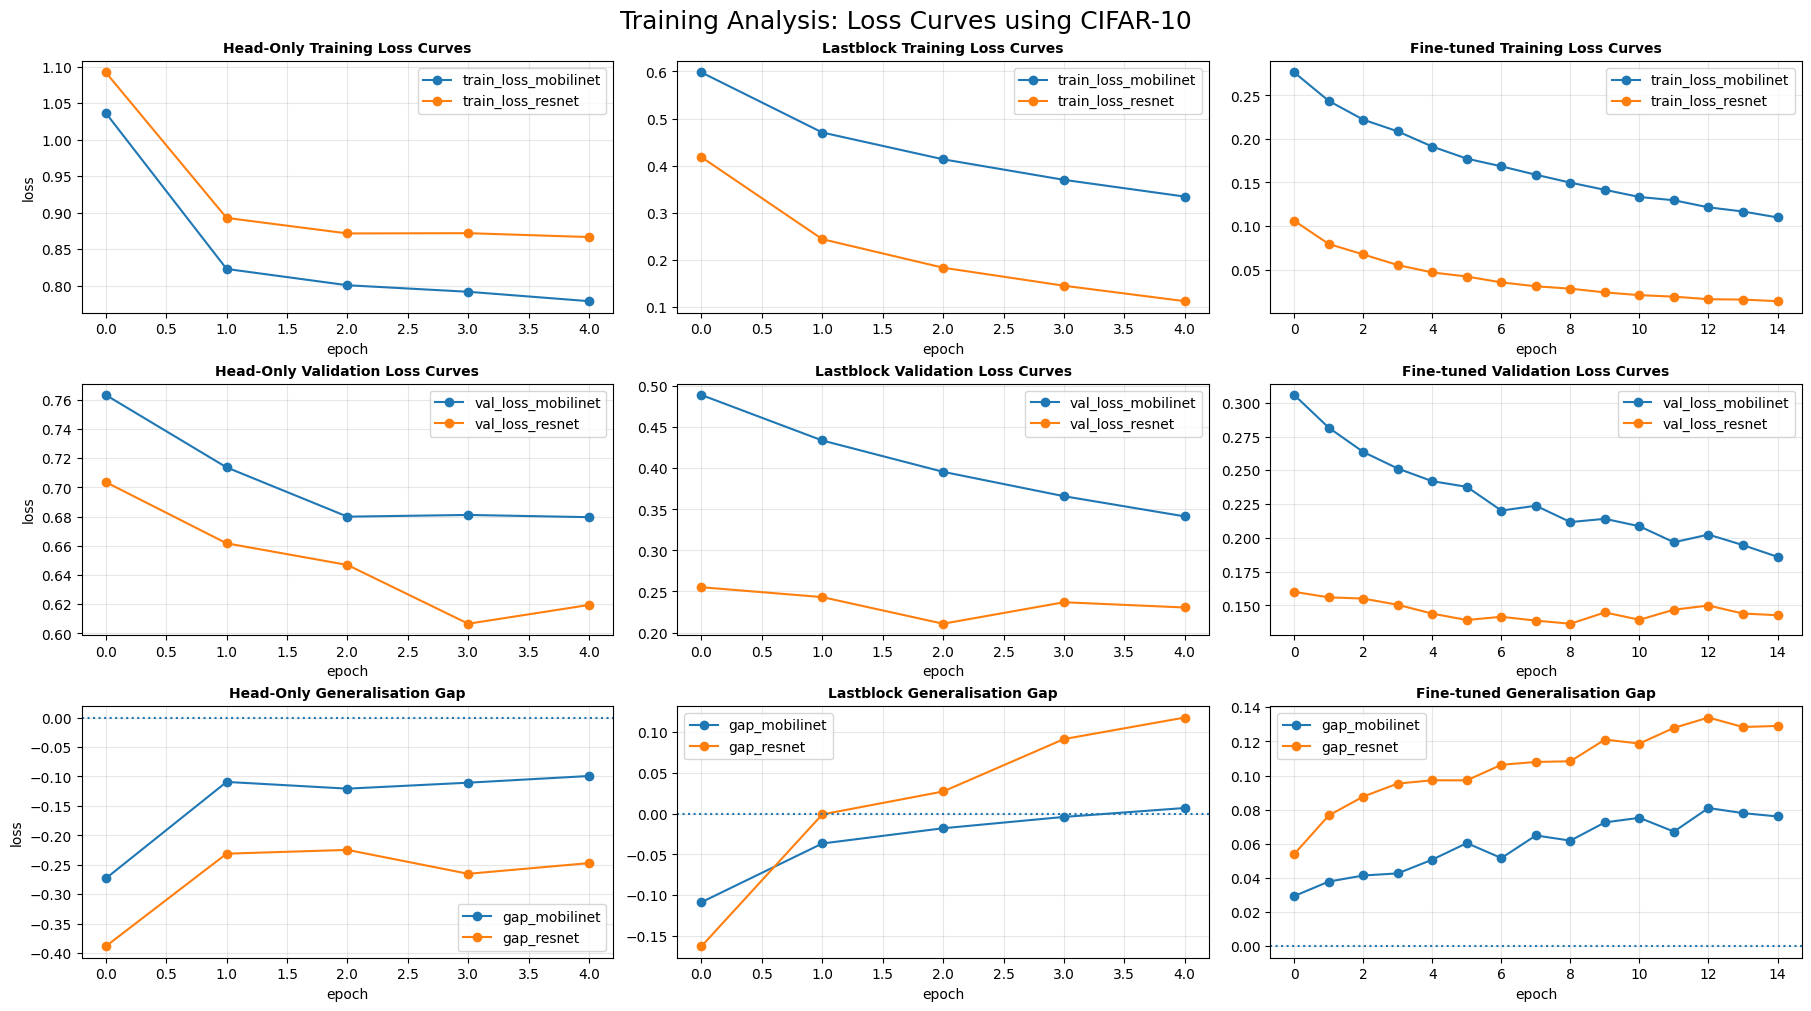

In [7]:
fig, ax = plt.subplots(3, 3, figsize=(18, 10), layout="constrained") # additional parameter 'layout' automatically adjusts subplots -> not to have overlaps
fig.suptitle(f"Training Analysis: Loss Curves using {dataset_name}", fontsize=18)

list_strategies=['Head-Only','Lastblock','Fine-tuned']
#to fill column by column
for i,(df_mobilinet, df_resnet) in enumerate(zip ([mobilinet_head,mobilinet_lastblock,mobilinet_finetuned],[resnet_head,resnet_lastblock,resnet_finetuned])):

    axis_labels=['epoch','loss'] if i==0 else  ['epoch','']  # to have loss label in y axis only in head column
    
    plot_training_analytics([df_mobilinet,df_resnet],ax[0,i],'train_loss',title=f'{list_strategies[i]} Training Loss Curves',labels=['train_loss_mobilinet','train_loss_resnet'],axis_labels=axis_labels)
    plot_training_analytics([df_mobilinet,df_resnet],ax[1,i],'val_loss',title=f'{list_strategies[i]} Validation Loss Curves',labels=['val_loss_mobilinet','val_loss_resnet'],axis_labels=axis_labels)
    plot_training_analytics([df_mobilinet,df_resnet],ax[2,i],'gap',title=f'{list_strategies[i]} Generalisation Gap',labels=['gap_mobilinet','gap_resnet'],axis_labels=axis_labels)
    ax[2,i].axhline(y=0,linestyle=':') # add line y=0

### Accuracy curves comparison

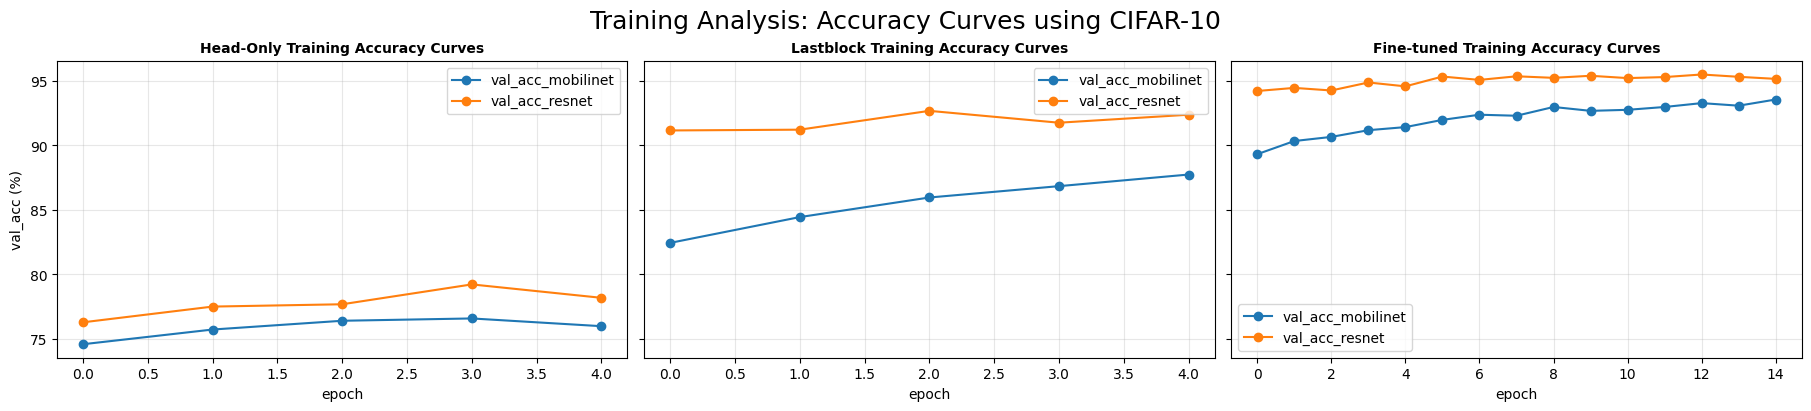

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4), sharey=True,layout="constrained") # additional parameter 'layout' automatically adjusts subplots -> not to have overlaps
fig.suptitle(f"Training Analysis: Accuracy Curves using {dataset_name}", fontsize=18)

list_strategies=['Head-Only','Lastblock','Fine-tuned']
for i,(df_mobilinet, df_resnet) in enumerate(zip ([mobilinet_head,mobilinet_lastblock,mobilinet_finetuned],[resnet_head,resnet_lastblock,resnet_finetuned])):
    axis_labels=['epoch','val_acc (%)'] if i==0 else  ['epoch','']  # to have loss label in y axis only in head column
    
    df_mobilinet['val_acc_percent'] = df_mobilinet['val_acc'] * 100
    df_resnet['val_acc_percent'] = df_resnet['val_acc'] * 100

    plot_training_analytics([df_mobilinet, df_resnet], ax[i], 'val_acc_percent', title=f'{list_strategies[i]} Training Accuracy Curves', labels=['val_acc_mobilinet','val_acc_resnet'], axis_labels=axis_labels)

### Max Accuracy

Collect all info in one df

In [9]:
data_list = []
for i,(df_mobilinet, df_resnet) in enumerate(zip ([mobilinet_head,mobilinet_lastblock,mobilinet_finetuned],[resnet_head,resnet_lastblock,resnet_finetuned])):
    data_list.append({'training_strategy':list_strategies[i], 'model': 'MobiliNet V2','max_val_acc':df_mobilinet['val_acc_percent'].max(),'epochs':len(df_mobilinet),'initial_weights':'Imagenet', 'data':dataset_name})

    data_list.append({'training_strategy': list_strategies[i], 'model': 'ResNet-18','max_val_acc':df_resnet['val_acc_percent'].max(),'epochs':len(df_resnet),'initial_weights':'Imagenet','data':dataset_name})

df_max_acc = pd.DataFrame(data_list)
df_max_acc

,training_strategy,model,max_val_acc,epochs,initial_weights,data
0,Head-Only,MobiliNet V2,76.58,5,Imagenet,CIFAR-10
1,Head-Only,ResNet-18,79.22,5,Imagenet,CIFAR-10
2,Lastblock,MobiliNet V2,87.74,5,Imagenet,CIFAR-10
3,Lastblock,ResNet-18,92.68,5,Imagenet,CIFAR-10
4,Fine-tuned,MobiliNet V2,93.56,15,Imagenet,CIFAR-10
5,Fine-tuned,ResNet-18,95.50,15,Imagenet,CIFAR-10


And plot

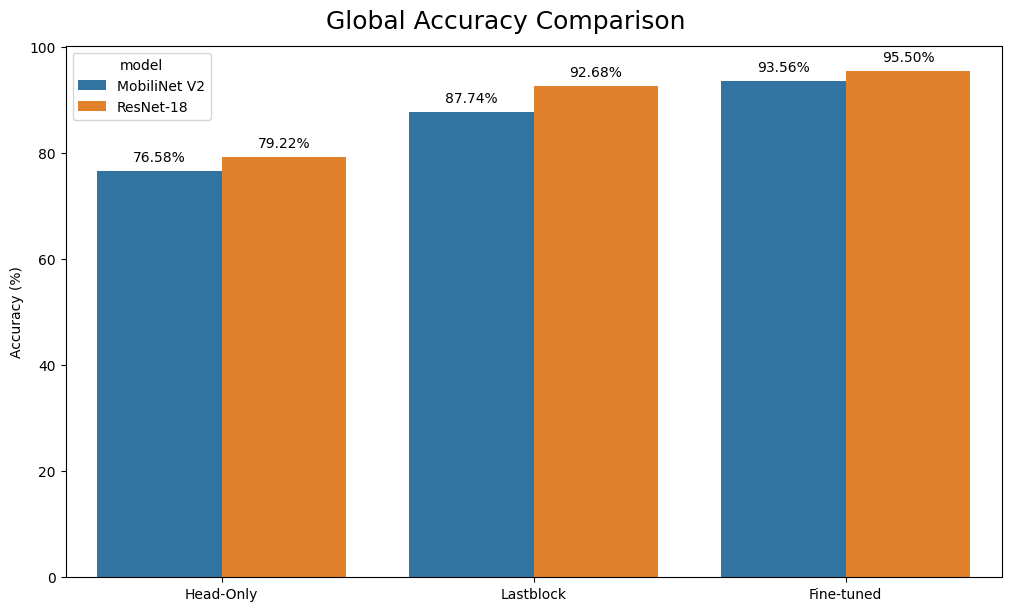

In [10]:
plt.figure(figsize=(10, 6), layout="constrained")
plt.suptitle("Global Accuracy Comparison", fontsize=18)

ax = sns.barplot(data=df_max_acc, x="training_strategy", y="max_val_acc", hue="model")

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', padding=5) # add percentage on top of bars
    
plt.ylabel("Accuracy (%)")
plt.xlabel('')
#plt.xticks(rotation=20)
#plt.grid(axis='y', alpha=0.3)
plt.show()

## Part II: Global Performance Comparison (MobileNet vs. ResNet)

For ResNet-18

In [11]:
resnet_report = classification_report(resnet_y_true, resnet_y_pred, output_dict=True)

print(f"Global Accuracy:    {resnet_report['accuracy'] * 100:.2f}% - the percentage of total correct answers")
print(f"Macro Precision:    {resnet_report['macro avg']['precision'] * 100:.2f}% - average of precision for every single class")
print(f"Weighted Precision: {resnet_report['weighted avg']['precision'] * 100:.2f}% - precision for every class, but multiply (weight) it by how many images are in that class")
print(f"Macro F1-Score:     {resnet_report['macro avg']['f1-score'] * 100:.2f}% - harmonic mean of Precision and Recall, averaged equally across all classes")
print(f"Weighted F1-Score:  {resnet_report['weighted avg']['f1-score'] * 100:.2f}%")

Global Accuracy:    94.83% - the percentage of total correct answers
Macro Precision:    94.87% - average of precision for every single class
Weighted Precision: 94.87% - precision for every class, but multiply (weight) it by how many images are in that class
Macro F1-Score:     94.82% - harmonic mean of Precision and Recall, averaged equally across all classes
Weighted F1-Score:  94.82%


In [12]:
df_resnet_report= pd.DataFrame(resnet_report).transpose().drop(
        ['macro avg', 'weighted avg', 'accuracy'], 
        axis=0, 
        errors='ignore' # Додано для безпеки
    )
df_resnet_report['model'] = 'resnet'
df_resnet_report.head(5)

,precision,recall,f1-score,support,model
0,0.957426,0.967,0.962189,1000.0,resnet
1,0.971831,0.966,0.968907,1000.0,resnet
2,0.974630,0.922,0.947585,1000.0,resnet
3,0.911111,0.861,0.885347,1000.0,resnet
4,0.945437,0.953,0.949203,1000.0,resnet


For MobiliNet V2

In [13]:
mobilinet_report = classification_report(mobilinet_y_true, mobilinet_y_pred, output_dict=True)

print(f"Global Accuracy:    {mobilinet_report['accuracy'] * 100:.2f}% - the percentage of total correct answers")
print(f"Macro Precision:    {mobilinet_report['macro avg']['precision'] * 100:.2f}% - average of precision for every single class")
print(f"Weighted Precision: {mobilinet_report['weighted avg']['precision'] * 100:.2f}% - precision for every class, but multiply (weight) it by how many images are in that class")
print(f"Macro F1-Score:     {mobilinet_report['macro avg']['f1-score'] * 100:.2f}% - harmonic mean of Precision and Recall, averaged equally across all classes")
print(f"Weighted F1-Score:  {mobilinet_report['weighted avg']['f1-score'] * 100:.2f}%")

Global Accuracy:    93.23% - the percentage of total correct answers
Macro Precision:    93.27% - average of precision for every single class
Weighted Precision: 93.27% - precision for every class, but multiply (weight) it by how many images are in that class
Macro F1-Score:     93.24% - harmonic mean of Precision and Recall, averaged equally across all classes
Weighted F1-Score:  93.24%


In [14]:
df_mobilinet_report= pd.DataFrame(mobilinet_report).transpose().drop(
        ['macro avg', 'weighted avg', 'accuracy'], 
        axis=0, 
        errors='ignore' # Додано для безпеки
    )
df_mobilinet_report['model'] = 'mobilinet'
df_mobilinet_report.head()

,precision,recall,f1-score,support,model
0,0.943888,0.942,0.942943,1000.0,mobilinet
1,0.965760,0.959,0.962368,1000.0,mobilinet
2,0.957292,0.919,0.937755,1000.0,mobilinet
3,0.853000,0.853,0.853000,1000.0,mobilinet
4,0.924303,0.928,0.926148,1000.0,mobilinet


Combine together into one df

In [15]:
df_class_report =pd.concat([df_mobilinet_report, df_resnet_report],axis=0).reset_index().rename(columns={'index': 'class_label'})

cols = ['precision', 'recall', 'f1-score']
df_class_report[cols] = (df_class_report[cols] * 100).round(2) # round
df_class_report['support']=df_class_report['support'].fillna(0).astype(int) # make int from float
df_class_report['class_label'] = df_class_report['class_label'].astype(int).apply(lambda x: class_labels[x])

df_class_report.sort_values(by='class_label')

,class_label,precision,recall,f1-score,support,model
0,airplane,94.39,94.2,94.29,1000,mobilinet
10,airplane,95.74,96.7,96.22,1000,resnet
1,automobile,96.58,95.9,96.24,1000,mobilinet
11,automobile,97.18,96.6,96.89,1000,resnet
2,bird,95.73,91.9,93.78,1000,mobilinet
12,bird,97.46,92.2,94.76,1000,resnet
3,cat,85.30,85.3,85.30,1000,mobilinet
13,cat,91.11,86.1,88.53,1000,resnet
4,deer,92.43,92.8,92.61,1000,mobilinet
14,deer,94.54,95.3,94.92,1000,resnet


In [16]:
def plot_class_analytics(df, ax, metric:str, interval=None, title:str=None,axis_labels=None):  
    #ax.set_title(f"Metric {metric}" else title, fontweight='bold', fontsize=10)

    ax = sns.barplot(data=df, x="class_label", y=metric, hue="model",ax=ax) #palette='viridis'

    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', padding=5) # add percentage on top of bars
        
 
    if axis_labels: 
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])
    #ax.set_xticks(rotation=20)
    #ax.grid(axis='y', alpha=0.3)
    if interval: ax.set_ylim(interval[0], interval[1])

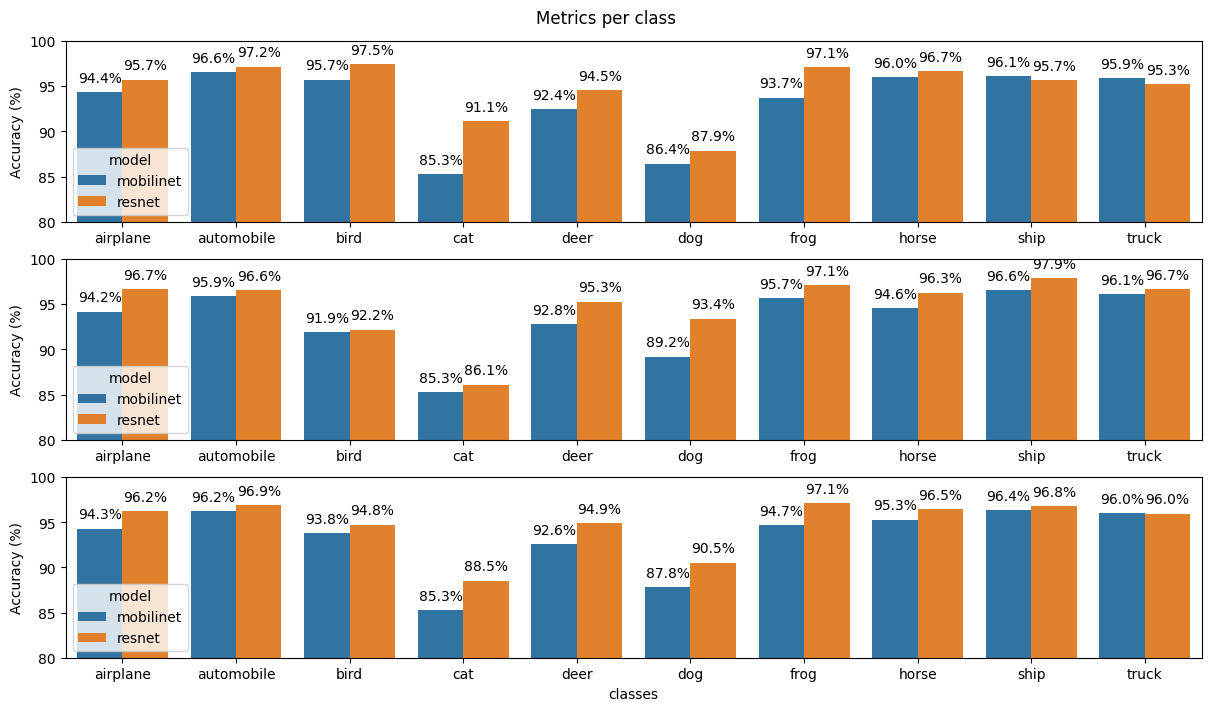

In [17]:
fig, ax = plt.subplots(3,1,figsize=(12, 7), layout="constrained")
plt.suptitle("Metrics per class")
plot_class_analytics(df_class_report,ax[0],'precision',interval=[80,100],axis_labels=['','Accuracy (%)'])
plot_class_analytics(df_class_report,ax[1],'recall',interval=[80,100],axis_labels=['','Accuracy (%)'])
plot_class_analytics(df_class_report,ax[2],'f1-score',interval=[80,100],axis_labels=['classes','Accuracy (%)'])
plt.show()

## Part III: Micro-Level Analysis (Confusion Matrices)
#### It is possible to define for each class (like for binary classification "One-vs-Rest")
Using confusion matrix we can see not only one single score like for accuracy for example, but also we can easily track where and how those mistakes occurred.

<br>In our case for CIFAR-100 we will firstly generate 100 matrices with 2x2 grid. It will show binary implementation of confusion matrices for each class separately. Then we will see confusion matrix in heatmap implementation which will help us to extract top 10 wrongly classified classes.

Binary confusion matrix:
$$\begin{bmatrix}
\text{True Positives (TP)} & \text{False Positives (FP)} \\
\text{False Negatives (FN)} & \text{True Negatives (TN)}
\end{bmatrix}$$

In [18]:
if type(resnet_y_true[0])!=str:
    #make y_true and y_pred to have str classes names not numbers
    resnet_y_true = [class_labels[i] for i in resnet_y_true]
    resnet_y_pred = [class_labels[i] for i in resnet_y_pred]

    #make y_true and y_pred to have str classes names not numbers
    mobilinet_y_true = [class_labels[i] for i in mobilinet_y_true]
    mobilinet_y_pred = [class_labels[i] for i in mobilinet_y_pred]
else: print('Already class labels instead of IDs')

In [19]:
#helper func
def print_conf_matr_by_classes(per_class_confusion_matrices, n:int):
    print(f'Confusion matrices for {n} classes\n')
    for i in range(n):
        print(f'{class_labels[i]}')
        print(per_class_confusion_matrices[i],'\n')

In [20]:
# calculates confusion matrix for each class
resnet_per_class_confusion_matrices = multilabel_confusion_matrix(resnet_y_true, resnet_y_pred, labels=class_labels)
print_conf_matr_by_classes(resnet_per_class_confusion_matrices,3)

Confusion matrices for 3 classes

airplane
[[8957   43]
 [  33  967]] 

automobile
[[8972   28]
 [  34  966]] 

bird
[[8976   24]
 [  78  922]] 



In [21]:
# calculates confusion matrix for each class
mobilinet_per_class_confusion_matrices = multilabel_confusion_matrix(mobilinet_y_true, mobilinet_y_pred, labels=class_labels)
print_conf_matr_by_classes(mobilinet_per_class_confusion_matrices,3)

Confusion matrices for 3 classes

airplane
[[8944   56]
 [  58  942]] 

automobile
[[8966   34]
 [  41  959]] 

bird
[[8959   41]
 [  81  919]] 



For multi-classes

In [22]:
mobilinet_overall_confusion_matrix = confusion_matrix(mobilinet_y_true, mobilinet_y_pred)
mobilinet_overall_confusion_matrix


array([[942,   1,   7,   6,   7,   2,   1,   4,  21,   9],
       [ 12, 959,   0,   1,   0,   1,   1,   1,   1,  24],
       [ 11,   0, 919,  20,  17,  13,  15,   4,   1,   0],
       [  2,   1,  11, 853,  14,  80,  26,   7,   5,   1],
       [  2,   0,   8,  18, 928,  14,  12,  15,   2,   1],
       [  1,   1,   7,  76,  10, 892,   6,   7,   0,   0],
       [  2,   2,   4,  17,   7,   9, 957,   1,   0,   1],
       [  3,   0,   3,   7,  21,  20,   0, 946,   0,   0],
       [ 16,   7,   1,   1,   0,   1,   3,   0, 966,   5],
       [  7,  22,   0,   1,   0,   0,   0,   0,   9, 961]])

In [23]:
resnet_overall_confusion_matrix = confusion_matrix(resnet_y_true, resnet_y_pred)
resnet_overall_confusion_matrix

array([[967,   0,   2,   1,   1,   0,   0,   2,  20,   7],
       [  3, 966,   0,   0,   0,   0,   0,   0,   4,  27],
       [ 11,   0, 922,  16,  18,  14,  13,   2,   4,   0],
       [  6,   0,   4, 861,  13,  89,  11,   7,   6,   3],
       [  3,   0,   9,  10, 953,   8,   3,  13,   1,   0],
       [  1,   0,   2,  40,   9, 934,   2,   9,   1,   2],
       [  3,   0,   4,  12,   4,   2, 971,   0,   1,   3],
       [  3,   1,   3,   3,  10,  16,   0, 963,   0,   1],
       [ 11,   4,   0,   1,   0,   0,   0,   0, 979,   5],
       [  2,  23,   0,   1,   0,   0,   0,   0,   7, 967]])

In [24]:
#correctly classified
print(f'Correctly class mobi: {mobilinet_overall_confusion_matrix.diagonal().sum()}')
print(f'Correctly class res: {resnet_overall_confusion_matrix.diagonal().sum()}')

Correctly class mobi: 9323
Correctly class res: 9483


In [25]:
def print_analytics_of_conf_matrix(y_true, y_pred, cm, target_class):
    # id str name problem
    if isinstance(target_class, str):
        target_class_id = class_labels.index(target_class)
        target_class_name = target_class
    else:
        target_class_id = target_class
        target_class_name = class_labels[target_class]

    print(f'>>> Confusion Matrix for: {target_class_name} (ID: {target_class_id})')
    print(cm[target_class_id]) 
    
    if isinstance(y_true[0], str):
        indices = [i for i, x in enumerate(y_true) if x == target_class_name]
    else:
        indices = [i for i, x in enumerate(y_true) if x == target_class_id]

    predictions_for_target = [y_pred[i] for i in indices]
    counts = Counter(predictions_for_target)

    print(f"\nWhen true image was '{target_class_name}', model predicted:")
    
    for pred, count in counts.most_common():
        pred_name = class_labels[pred] if isinstance(pred, int) else pred
        
        pct = (count / len(indices)) * 100
        print(f" - {pred_name:<12}: {count} times ({pct:.1f}%)")
    print("-" * 40)

In [26]:
print_analytics_of_conf_matrix(resnet_y_true,resnet_y_pred,resnet_per_class_confusion_matrices,'cat')

>>> Confusion Matrix for: cat (ID: 3)
[[8916   84]
 [ 139  861]]

When true image was 'cat', model predicted:
 - cat         : 861 times (86.1%)
 - dog         : 89 times (8.9%)
 - deer        : 13 times (1.3%)
 - frog        : 11 times (1.1%)
 - horse       : 7 times (0.7%)
 - airplane    : 6 times (0.6%)
 - ship        : 6 times (0.6%)
 - bird        : 4 times (0.4%)
 - truck       : 3 times (0.3%)
----------------------------------------


In [27]:
def conf_matrix_heatmap(cm, ax,dots_to_plot=None, title:str=None,class_labels=None):  
   
    if title: ax.set_title(title, fontweight='bold', fontsize=10)
    sns.heatmap(cm, 
                annot=False, # if true numbers will appear
                cmap='Blues', # color 'Blues' or 'viridis' 
                vmax=20,
                cbar_kws={'label': 'Number of Images'},
                ax=ax
                ) 
    if dots_to_plot:
        x_coords = []
        y_coords = []

        for true_id, pred_id in dots_to_plot:
            x_coords.append(pred_id + 0.5)  # -> to be in middle of square
            y_coords.append(true_id + 0.5)
            
            print(f"Marking: {class_labels[true_id]} (ID {true_id}) -> {class_labels[pred_id]} (ID {pred_id})")
    
        ax.scatter(x_coords, y_coords, color='red', marker='o', linewidth=2)  
    
    ax.set_ylabel('True Class ID')
    ax.set_xlabel('Predicted Class ID')

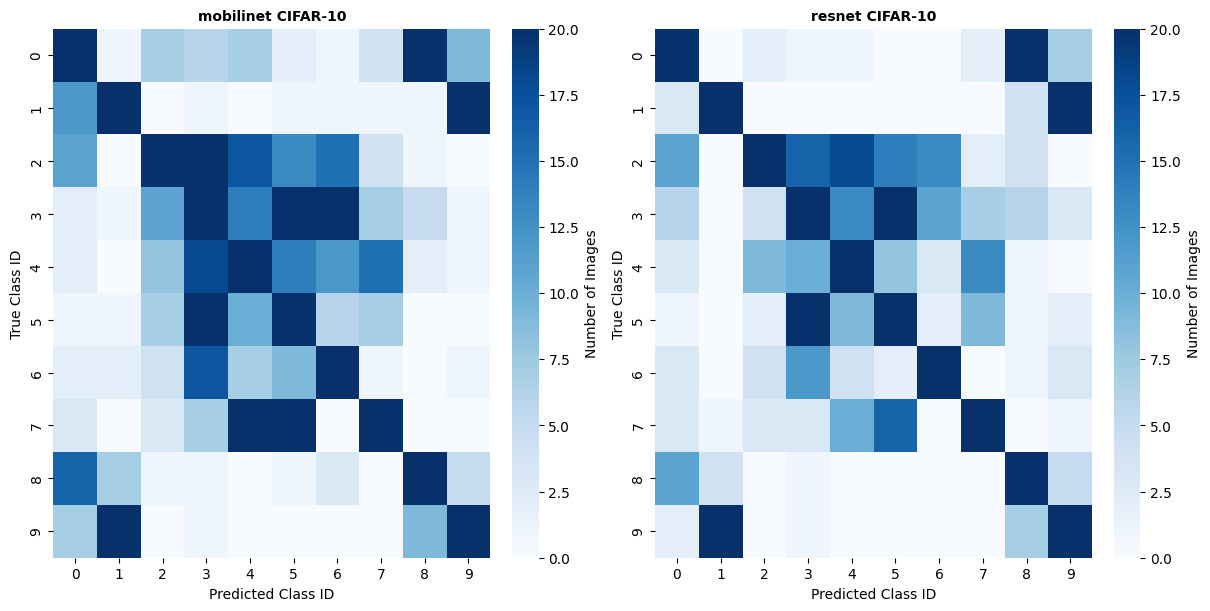

In [28]:
fig, ax = plt.subplots(1,2,figsize=(12, 6), layout="constrained")
conf_matrix_heatmap(mobilinet_overall_confusion_matrix,ax[0],title=f'mobilinet {dataset_name}')
conf_matrix_heatmap(resnet_overall_confusion_matrix,ax[1],title=f'resnet {dataset_name}')

In [29]:
def get_top_confusions(cm_, class_names, top_n=10):
    cm = cm_.copy()
    np.fill_diagonal(cm, 0) # Zero out correct predictions (diagonal) to find errors
    
    pairs = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > 0:
                pairs.append((i, j, cm[i, j]))
    
    # Sort in descending order
    pairs.sort(key=lambda x: x[2], reverse=True)
    
    print(f">>> Top {top_n} Confusions <<<")
    for i in range(min(top_n, len(pairs))):
        true_idx, pred_idx, count = pairs[i]
        
        t_name = class_names[true_idx] if class_names else str(true_idx)
        p_name = class_names[pred_idx] if class_names else str(pred_idx)
        
        print(f"True: {class_labels.index(t_name)} - {t_name:<15} Predicted: {class_labels.index(p_name)} - {p_name:<15} Count: {count}")
        
get_top_confusions(resnet_overall_confusion_matrix, class_labels)

>>> Top 10 Confusions <<<
True: 3 - cat             Predicted: 5 - dog             Count: 89
True: 5 - dog             Predicted: 3 - cat             Count: 40
True: 1 - automobile      Predicted: 9 - truck           Count: 27
True: 9 - truck           Predicted: 1 - automobile      Count: 23
True: 0 - airplane        Predicted: 8 - ship            Count: 20
True: 2 - bird            Predicted: 4 - deer            Count: 18
True: 2 - bird            Predicted: 3 - cat             Count: 16
True: 7 - horse           Predicted: 5 - dog             Count: 16
True: 2 - bird            Predicted: 5 - dog             Count: 14
True: 2 - bird            Predicted: 6 - frog            Count: 13


Marking: cat (ID 3) -> dog (ID 5)
Marking: dog (ID 5) -> cat (ID 3)
Marking: cat (ID 3) -> dog (ID 5)
Marking: dog (ID 5) -> cat (ID 3)


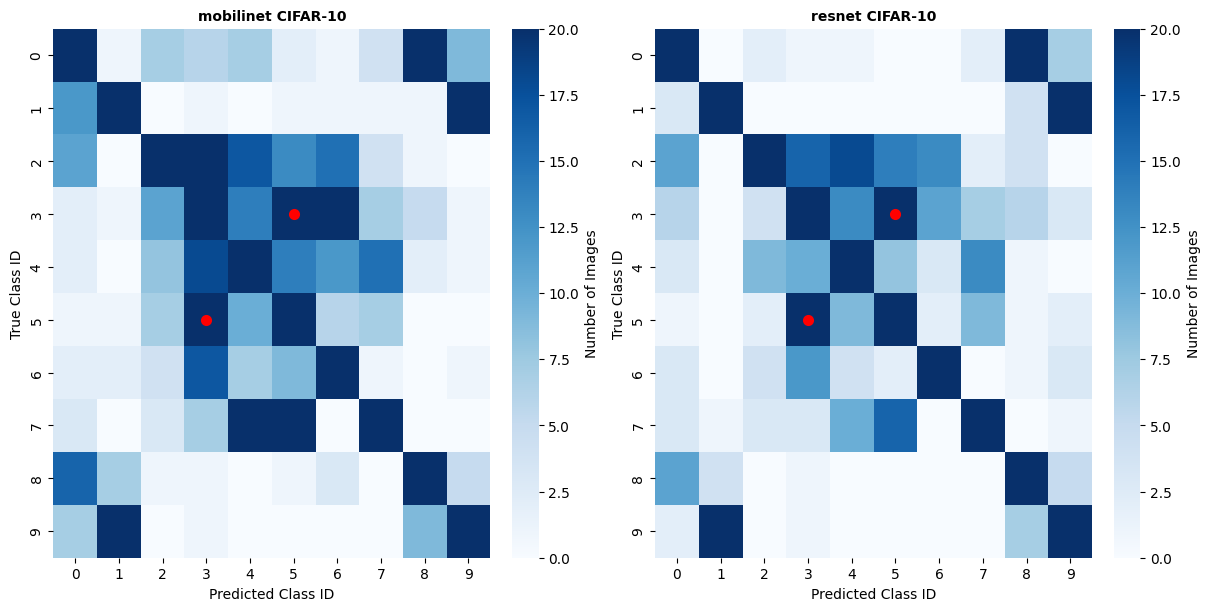

In [30]:
fig, ax = plt.subplots(1,2,figsize=(12, 6), layout="constrained")
conf_matrix_heatmap(mobilinet_overall_confusion_matrix, ax[0], title=f'mobilinet {dataset_name}', dots_to_plot=[[3,5], [5,3]],class_labels=class_labels)
conf_matrix_heatmap(resnet_overall_confusion_matrix, ax[1], title=f'resnet {dataset_name}', dots_to_plot=[[3,5], [5,3]],class_labels=class_labels)

In [31]:
for i,j in enumerate(class_labels):
    print(f', {i} - {j}',end='')

, 0 - airplane, 1 - automobile, 2 - bird, 3 - cat, 4 - deer, 5 - dog, 6 - frog, 7 - horse, 8 - ship, 9 - truck

## Part IV: CLass-Level Analysis

In [32]:
def print_distribution_per_class_vert(df_classes, ax,list_classes, interval=None):
    # Filter rows
    sub = df_classes[df_classes['class_label'].isin(list_classes)].copy()
    sub = sub.sort_values(by='precision', ascending=False) # Optional: Descending looks better vertical

    # Melt data (same as before)
    df_melted = sub[['class_label', 'precision', 'recall', 'f1-score']].melt(
        id_vars='class_label',
        var_name='Metric',
        value_name='Score'
    )
    sns.barplot(
        data=df_melted,
        x='class_label',   # categorical
        y='Score',       # numerical
        hue='Metric',    
        palette='viridis',
        ax=ax,
    )

    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', padding=5) # add percentage on top of bars
    
    if interval: ax.set_ylim(interval[0], interval[1])
    ax.set_ylabel("Accuracy (%)")
    ax.set_xlabel('class labels')

Worst

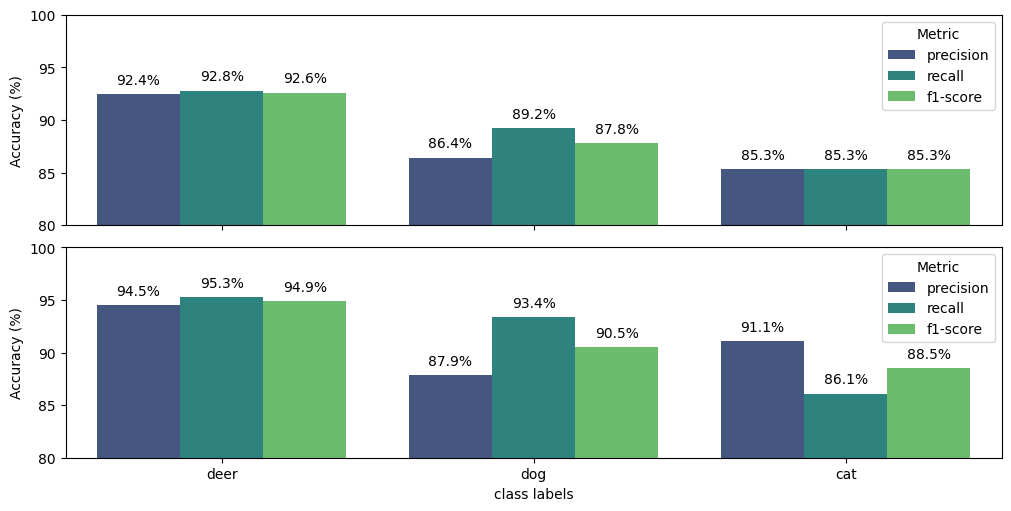

In [33]:
target_classes = ['deer', 'cat', 'dog']
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True, layout="constrained")

print_distribution_per_class_vert(df_class_report[df_class_report['model']=='mobilinet'], axes[0], target_classes, interval=[80,100])
print_distribution_per_class_vert(df_class_report[df_class_report['model']=='resnet'], axes[1], target_classes, interval=[80,100])
plt.show()

Best

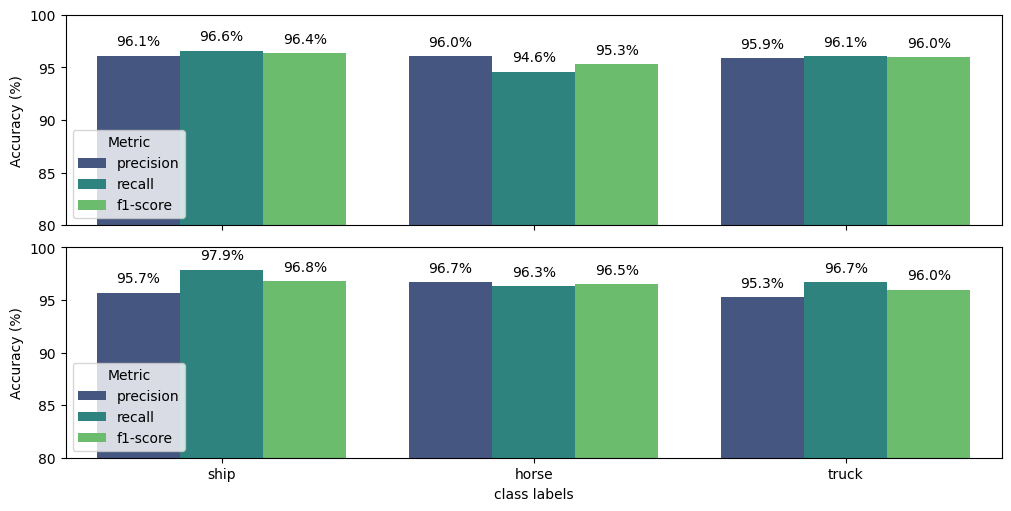

In [34]:
target_classes = ['horse', 'ship', 'truck']
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True, layout="constrained")

print_distribution_per_class_vert(df_class_report[df_class_report['model']=='mobilinet'], axes[0], target_classes, interval=[80,100])
print_distribution_per_class_vert(df_class_report[df_class_report['model']=='resnet'], axes[1], target_classes, interval=[80,100])

## Part V: Qualitative Analysis (Visualizing Predictions)

In [44]:
def visualize_model_predictions(model, loader, class_labels,  target_class=None, num_images=5, device="cpu"):
    samples = []
    
    if target_class is not None:  target_class_id = class_labels.index(target_class) 
    
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for images, labels in loader: 
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            # Define filter
            if target_class:
                mask = (labels == target_class_id) & (preds != target_class_id)
            else:
                mask = torch.ones_like(labels, dtype=torch.bool)
            
            # Store matching images
            if mask.any():
                for img, t, p in zip(images[mask], labels[mask], preds[mask]):
                    samples.append((img.cpu(), t.item(), p.item()))
                    if len(samples) >= num_images: break
            
            if len(samples) >= num_images: break
        
    if not samples: return print("No images found.")

    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    plt.figure(figsize=(10,5))
    for i in range(num_images) :
        img_tensor, true_id, pred_id = samples[i]
        plt.subplot(1,5,i+1)
        img = img_tensor.permute(1, 2, 0).numpy()
        img = (std * (img) + mean) 

        plt.axis("off")
        plt.title(f"True : {class_labels[true_id]}, Pred: {class_labels[pred_id]}",fontsize=10)
        plt.imshow(img)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.027450978279113747..1.0000000076293944].


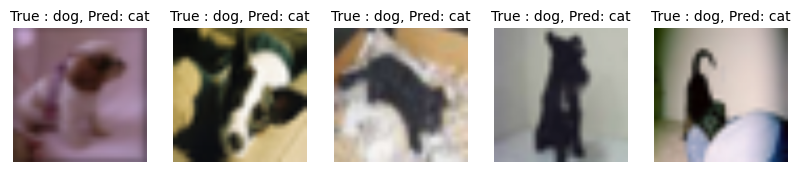

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12156863188743594..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9450980482101441].


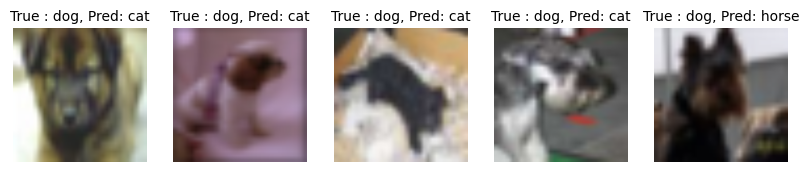

In [45]:
visualize_model_predictions(resnet_model, test_loader,class_labels=class_labels,target_class='dog')
visualize_model_predictions(mobilinet_model, test_loader,class_labels=class_labels,target_class='dog')

## Part VI: Efficiency Analysis (Speed & Size)

In [ ]:
def get_efficiency_metrics(model, loader, device, model_path):
    model.eval()

    #model size
    size_mb = os.path.getsize(model_path) / (1024 * 1024)

    #total numb of parameters
    params = sum(p.numel() for p in model.parameters())
    
    num_samples = 0
    start_time = time.time()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            num_samples += images.size(0)
            
            if i >= 10: break 
            
    end_time = time.time()
    avg_inference_time = (end_time - start_time) / num_samples

    print(f">>> Global Efficiency & Confidence Metrics")
    print(f"Model Size:       {size_mb:.2f} MB")
    print(f"Total Params:     {params:,}")
    print(f"Inference Time:   {avg_inference_time*1000:.2f} ms per image")
  
    return size_mb, params, avg_inference_time

_ = get_efficiency_metrics(resnet_model, test_loader, device, resnet_model_path)

>>> Global Efficiency & Confidence Metrics
Model Size:       42.73 MB
Total Params:     11,181,642
Inference Time:   25.42 ms per image


(42.733238220214844, 11181642, 0.02541657503355633)

## Summary table

In [46]:
#stylise df
cols = [
    'model',
    'initial_weights',
    'data',
    'training_strategy',
    # 'learning_rate',
    'max_val_acc',
    'epochs',
]

styled_df = df_max_acc[cols].style.format({
    'max_val_acc': '{:.2f}',
}).hide(axis="index")

#styled_df.to_csv()

#to save table
dfi.export(styled_df, ROOT / 'project_report' / 'images' /'model_performance.png', table_conversion='matplotlib')
styled_df

model,initial_weights,data,training_strategy,max_val_acc,epochs
MobiliNet V2,Imagenet,CIFAR-10,Head-Only,76.58,5
ResNet-18,Imagenet,CIFAR-10,Head-Only,79.22,5
MobiliNet V2,Imagenet,CIFAR-10,Lastblock,87.74,5
ResNet-18,Imagenet,CIFAR-10,Lastblock,92.68,5
MobiliNet V2,Imagenet,CIFAR-10,Fine-tuned,93.56,15
ResNet-18,Imagenet,CIFAR-10,Fine-tuned,95.50,15
